<a href="https://colab.research.google.com/github/Divishalakshmi/computer_architecture/blob/master/Image_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Caption Generator**

**Image caption generation using ml algorithms**

In [ ]:
#importing required libraries
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from glob import glob


import string
import os
#import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

Data loading and preprocessing

In [ ]:
#loading dataset into colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# defining all the paths to the files that we require and saving the images id and their captions.
token_path = "/content/drive/MyDrive/Flickr8k_text/Flickr8k.token.txt"
train_images_path = '/content/drive/MyDrive/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = '/content/drive/MyDrive/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = '/content/drive/MyDrive/Flickr8k_text/Flickr8k_Dataset/Flicker8k_Dataset/'
glove_path = '/content/drive/MyDrive/glove.6B.200d.txt'

doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [ ]:

images = glob(images_path+'*.jpg')
len(images)

1867

In [ ]:
images[:5]

['/content/drive/MyDrive/Flickr8k_text/Flickr8k_Dataset/Flicker8k_Dataset/2034553054_b00c166895.jpg',
 '/content/drive/MyDrive/Flickr8k_text/Flickr8k_Dataset/Flicker8k_Dataset/2057306459_2f52ce648e.jpg',
 '/content/drive/MyDrive/Flickr8k_text/Flickr8k_Dataset/Flicker8k_Dataset/2062607137_dac194ad02.jpg',
 '/content/drive/MyDrive/Flickr8k_text/Flickr8k_Dataset/Flicker8k_Dataset/2068960566_21e85ae0dc.jpg',
 '/content/drive/MyDrive/Flickr8k_text/Flickr8k_Dataset/Flicker8k_Dataset/2054308369_f9c6ec7815.jpg']

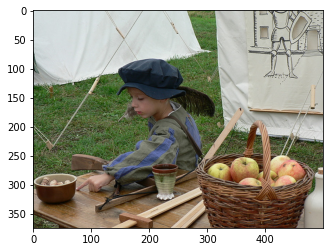

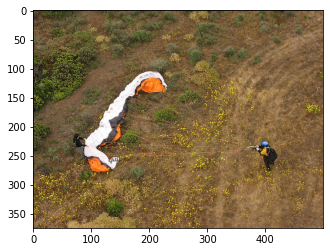

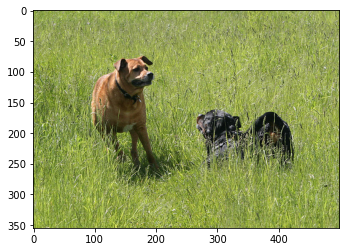

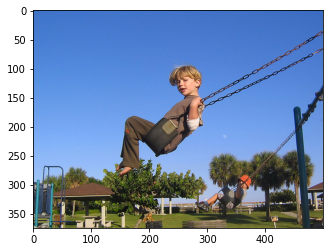

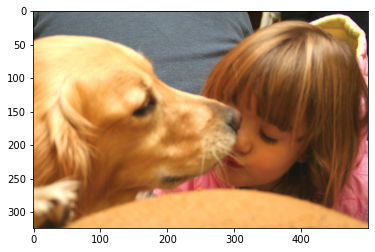

In [ ]:
for i in range(5):
  plt.figure()
  x=plt.imread(images[i])
  plt.imshow(x)

In [ ]:
#we are creating a dictionary named “descriptions” which contains the name of the image as keys 
#and a list of the 5 captions for the corresponding image as values.
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)
print(descriptions['1000268201_693b08cb0e'])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [ ]:
#we are cleaning text to get rid of punctuation and convert our descriptions to lowercase.
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

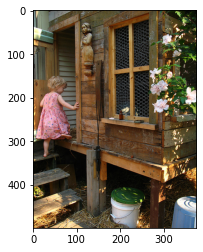

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [ ]:
#visulaizing example of image and its captions
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [ ]:
#we create a vocabulary of all the unique words present across all the 8000*5 (i.e. 40000) 
#image captions in the data set. We have 8828 unique words across all the 40000 image captions.
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [ ]:
# saving the image id’s and their new cleaned captions in the same format as the token.txt file
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [ ]:
#loading all the 6000 training image id’s in a variable train from the ‘Flickr_8k.trainImages.txt’ file
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [ ]:
#saving all the training and testing images in train_img and test_img lists respectively
img = glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

In [ ]:
#loading the descriptions of the training images into a dictionary. 
# we are adding two tokens in every caption, which are ‘startseq’ and ‘endseq’
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [ ]:
#Creating a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [ ]:
#make our model more robust we will reduce our vocabulary to only
# those words which occur at least 10 times in the entire corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


In [ ]:
#creating two dictionaries to map words to an index and vice versa.
# we are appending 1 to our vocabulary since we appended 0’s to make all captions of equal length.
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1


In [ ]:
#finding out max length of a caption can be,since we cannot have captions of arbitrary length.
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [ ]:
# Get the InceptionV3 model trained on imagenet data
model = InceptionV3(weights='imagenet')
# Remove the last layer (output softmax layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

In [ ]:
embeddings_index = {} 
f = open(os.path.join('/content/drive/MyDrive/glove.6B.200d.txt', 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [ ]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 200)      332000      input_5[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 38, 200)      332000      input_11[0][0]                   
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2048)         0           input_10[0][0]                   
____________________________________________________________________________________________

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

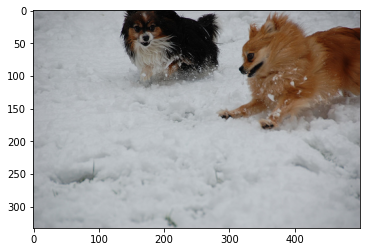

Greedy Search: jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack
Beam Search, K = 3: gathering jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack
Beam Search, K = 5: gathering jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack
Beam Search, K = 7: gathering jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack
Beam Search, K = 10: gathering jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack jack

In [ ]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

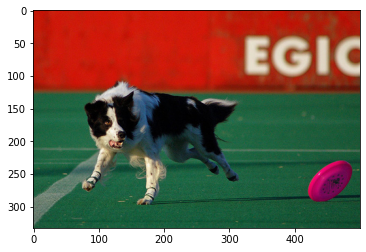

Greedy: blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket
Beam Search, K = 3: blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket
Beam Search, K = 5: blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket blanket
Beam Search, K = 7: blanket blanket blanket blanket blanket blan

In [ ]:
pic = list(encoding_test.keys())[1]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))

In [ ]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
 465/2000 [=====>........................] - ETA: 11:49 - loss: 3.5486

UnknownError: ignored